## Advanced Lane Finding Project

The goals / steps of this project are the following:

1. [Camera Calibration](#calibration)
2. [Distortion Correction](#distortion)
3. [Tranformations To A Binary Image](#transformations)
4. [Perspective Transform](#perspective)
5. [Detect Line Boundaries](#boundaries)
5. [Lane Curvature & Vehicle Center](#curvature)
5. [Unwarp Image](#unwarp)
7. [Render Lane Lines](#render)

---

In [ ]:
rows = 4
cols = len(images)//rows
    
fig=plt.figure(figsize=(200, 200))

fig.add_subplot(rows, cols, i + 1)

## Setup

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
DEBUG = False
SHOW_IMAGES = False

## Camera Calibration <a name="calibration"></a>

Goal: Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
def calibrate_camera(nx, ny, images, DEBUG = False, SHOW_IMAGES = False):
    
    """
    Calibrate camera using a set of calibration images with chessboards.
    Returns:
        mtx: Camera Matrix
        dist: Distortion coefficients
    """

    # 3-D points: (x, y, z)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.


    # Step through the list and search for chessboard corners
    for i in range(0, len(images)):
        
        # Read Image
        img = cv2.imread(images[i])
        
        # Convert to Gray Scale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        
        if (DEBUG):
            print(f"Image {images[i]} ({i}/{len(images)}) - Corners Found: {ret}")

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                   
    # Calibrate Camera using object points and image points
    # ret, mtx, dist, rvecs, tvecs - Ignoring irrelvant outputs for this project
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, 
                                             gray.shape[::-1],None,None)
    
    
    # Return Camera matrix and distortion coefficients
    return mtx, dist

## Distortion Correction <a name="distortion"></a>

Goal: Apply a distortion correction to raw images.

In [4]:
def undistort_image(img, mtx, dist):
    
    """
    Undistorts the image after camera calibration.
    Returns:
        img: Undistorted Image
    """
    
    return cv2.undistort(img, mtx, dist, None, mtx)

## Transformation to Binary Image <a name="transformations"></a>
Goal: Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
# Helper Functions
def get_gradient(img, vertical_gradient = True, sobel_kernel=3):
    
    # Calculate the gradient
    return cv2.Sobel(img, cv2.CV_64F, vertical_gradient, not(vertical_gradient))

def scale_mtx_to_8bit(mtx):
    
    scale_factor = np.max(mtx)/255 
    return (mtx/scale_factor).astype(np.uint8) 

def apply_thresholds(mtx, threshold=(0,255), scale = False):
    
    # Scale the matrix to 8-bits
    base = scale_mtx_to_8bit(mtx) if scale else mtx

    # Prepare a binary matrix of equal size to the base
    binary = np.zeros_like(base)
    
    # Apply thresholds - "Activate" pixels that meet criteira
    binary[(base >= threshold[0]) & (base <= threshold[1])] = 1
    
    return binary

In [6]:
# Gradient
def apply_gradient_thresholds(gradient, threshold=(0,255)):
    
    # Get the absolute gradient
    abs_sobel = np.absolute(gradient)
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(abs_sobel, threshold, scale = True)

# Magnitude
def apply_magnitude_thresholds(gradient_x, gradient_y, threshold=(0, 255)):
    
    # Calculate the gradient magnitude
    magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(magnitude, threshold, scale = True)

# Direction
def apply_direction_thresholds(gradient_x, gradient_y, threshold=(0, np.pi/2)):
    
    # Take the absolute value of the gradient direction, 
    
    abs_gradient_direction = np.arctan2(np.absolute(gradient_y), np.absolute(gradient_x))
    
    # Apply thresholds in a binary matrix
    return apply_thresholds(abs_gradient_direction, threshold)

In [7]:
# Gradient Pipeline
def apply_gradient_pipeline(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Calculate the gradient
    sobel_x = get_gradient(gray, True, sobel_kernel = 7)
    sobel_y = get_gradient(gray, False, sobel_kernel = 7)

    gradient_x_mask = apply_gradient_thresholds(sobel_x, threshold = (20,220))
    direction_mask = apply_direction_thresholds(sobel_x, sobel_y, threshold = (40*np.pi/180, 70*np.pi/180))
    magnitude_mask = apply_magnitude_thresholds(sobel_x, sobel_y, threshold = (50, 200))
    
    combined = np.zeros_like(direction_mask)
    combined[(gradient_x_mask == 1) & ((magnitude_mask == 1) & (direction_mask == 1))] = 1
    
    return combined

In [8]:
# Color
def apply_red_threshold(img, threshold = (0, 255)):
    
    R = img[:,:,0]
    return apply_thresholds(R, threshold)

def apply_saturation_threshold(img, threshold = (0, 255)):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    return apply_thresholds(S, threshold)

def apply_color_pipeline(img):
    
    R_mask = apply_red_threshold(img, (210,255))
    S_mask = apply_saturation_threshold(img, (90, 255))
    
    combined = np.zeros_like(S_mask)
    combined[(R_mask == 1) & (S_mask == 1)] = 1
    
    return combined

In [9]:
def get_thresholded_image(img):

    gradient_masks = apply_gradient_pipeline(img)
    color_masks = apply_color_pipeline(img)
    
    combined = np.zeros_like(color_masks)
    combined[(gradient_masks == 1) | (color_masks == 1)] = 1
    
    return combined

## Perspective Transform <a name="perspective"></a>
Goal: Apply a perspective transform to rectify binary image ("birds-eye view").

In [69]:
def apply_perspective_transform(img, src, dst):
    
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return M, Minv, warped

def apply_lane_birds_eye_view(img):
    
    height = img.shape[0]
    width = img.shape[1]

    src = np.float32([[240,  710],  # Bottom left
                      [590,  450],  # Top left
                      [740,  450],  # Top right
                      [1150, 710]]) # Bottom right


    dst = np.float32([[width*.15,  height],  # Bottom left
                      [width*.15,  0],  # Top left
                      [width*.85,  0],  # Top right
                      [width*.85, height]]) # Bottom right   

    return apply_perspective_transform(img, src, dst)


In [66]:
def draw_lines_from_points(img, points, color=[255, 0, 0], thickness=3):
    
    for i in range (0, len(points)):
        x1,y1 = points[i]
        x2,y2 = points[i+1] if i+1 < len(points) else points[0]

        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

## Detect Line Boundaries <a name="boundaries"></a>
Goal: Detect lane pixels and fit to find the lane boundary.

In [76]:
def get_activation_peaks(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return histogram, leftx_base, rightx_base

## Lane Curvature & Vehicle Center <a name="curvature"></a>
Goal: Determine the curvature of the lane and vehicle position with respect to center.

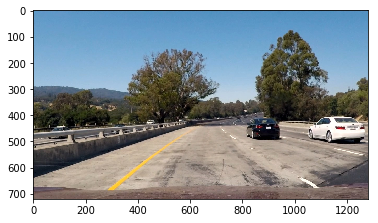

In [78]:
img = mpimg.imread(test_images[0]) 
plt.imshow(img)

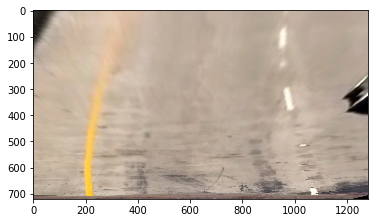

In [87]:
M, Minv, processed_image = apply_lane_birds_eye_view(img)
plt.imshow(processed_image, cmap='gray')

210 969


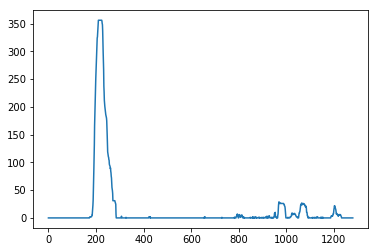

In [86]:
histogram, leftx_base, rightx_base = get_activation_peaks(test)

print(leftx_base, rightx_base)
plt.plot(histogram)

## Unwarp image <a name="unwarp"></a>
Goal: Warp the detected lane boundaries back onto the original image.

## Render Lane Lines <a name="render"></a>
Goal: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

# Final Pipeline

In [10]:
# Number of Corners
nx = 9
ny = 6

# Make a list of calibration images
calibration_path = './camera_cal/calibration*.jpg'
cal_images = glob.glob(calibration_path)

# Get camera metrix and distortion coefficient
mtx, dist = calibrate_camera(nx, ny, cal_images, DEBUG, SHOW_IMAGES)

In [84]:
def (img): 
    
    processed_image = undistort_image(img, mtx, dist)
    processed_image = get_thresholded_image(processed_image) 
    
    M, Minv, processed_image = apply_lane_birds_eye_view(processed_image)

    
    return processed_image

In [12]:
# Make a list of calibration images
test_image_path = './test_images/*.jpg'
test_images = glob.glob(test_image_path)

In [50]:
for fname in test_images:
    
    img = mpimg.imread(fname) 
    processed_image = undistort_image(img, mtx, dist)
    
    processed_image = get_thresholded_image(processed_image)

NameError: name 'test_images' is not defined